
# *DE FLEX - Coderhouse - Entregable 1*
### *Autor: Illak Zapata*


---



# Manejo de claves personales

El siguiente bloque de código nos permite manejar nuestras claves de forma "privada". De esta forma este notebook exige que se cargue un archivo JSON con las distintas claves que queremos ocultar hacia el público. Usted puede subir un JSON con sus propias claves.

El archivo JSON tiene el siguiente formato (o esquema):

```
{
    "newsapi_key": "XXXXXXXXXXXXXXXXXX",
    "redshift_host": "XXXXXXXXXXXXXXXXXX",
    "redshift_port": "XXXX",
    "redshift_user": "XXXXXXXXXXXXXXXXXX",
    "redshift_pass": "XXXXXXXXXXXXXXXXXX",
    "redshift_database": "XXXXXXXXXXXXXXXXXX"
}
```



In [1]:
# Import the libraries.
from google.colab import files
import io
import json

# Use files.upload to produce the "Choose Files" button below, then select your file.
uploaded = files.upload()

# Use io.BytesIO to decode the file, then json.load to open it.
file = io.BytesIO(uploaded['keys.json'])
credentials = json.load(file)

Saving keys.json to keys.json


# Presentación de la API que usaremos

Vamos a hacer uso de la API de [NewsApi](https://newsapi.org/). El sitio lo describe como una **REST API** fácil de usar, que devuelve un **JSON** con artículos de noticias nuevos e históricos, publicados por  80.000 fuentes de todo el mundo. Cuenta una [versión gratuita](https://newsapi.org/pricing) con algunas limtiaciones pero las suficientes para lograr nuestro objetivo en este TP.


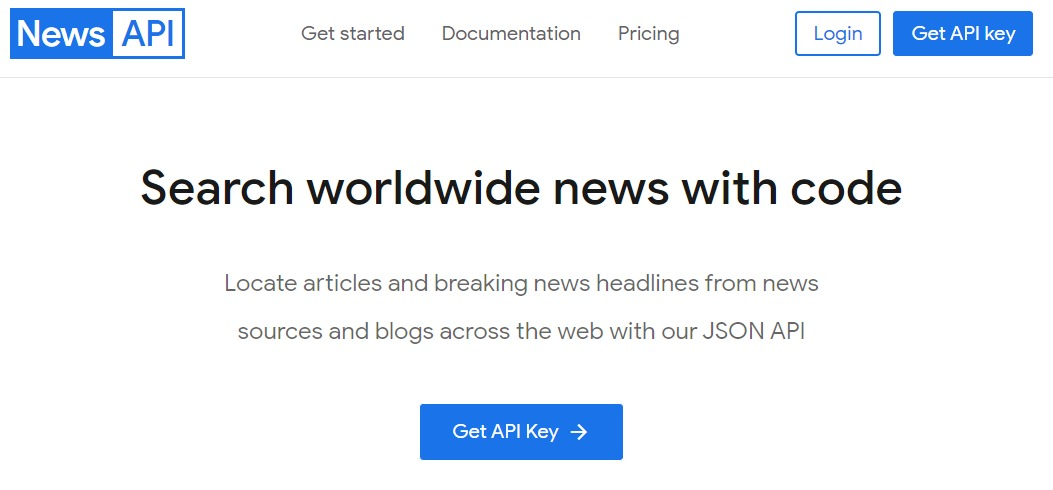

# Obtención de datos

En primer lugar vamos a importar la libreria `requests` para "comunicarnos" con la API.

In [2]:
import requests

Podemos ver la documentación de la API [aquí](https://newsapi.org/docs/endpoints/everything).

In [3]:
# para replicar el GET de ejempl:
# GET https://newsapi.org/v2/everything?q=Apple&from=2023-05-26&sortBy=popularity&apiKey=API_KEY

# Por defecto, la versión gratuita nos trae noticias del último mes (o últimos 30 días)
query = {'q':'data engineer',
         'p':1,
         'apiKey':credentials['newsapi_key']}

response = requests.get('https://newsapi.org/v2/everything', params=query)
#print(response.json())
#print(response.encoding)
#print(response.content.decode('utf-8'))

{'status': 'ok', 'totalResults': 2140, 'articles': [{'source': {'id': 'wired', 'name': 'Wired'}, 'author': 'Caitlin\xa0Harrington', 'title': 'Should You Get Paid for Teaching a Chatbot to Do Your Job?', 'description': 'Data from top-performing employees can create AI helpers that boost everyone’s productivity—but also create new concerns over fair pay.', 'url': 'https://www.wired.com/story/should-you-get-paid-for-teaching-a-chatbot-to-do-your-job/', 'urlToImage': 'https://media.wired.com/photos/64597612c30f50376ee87380/191:100/w_1280,c_limit/money_chatbot_pay_biz_GettyImages-1445809854-(1).jpg', 'publishedAt': '2023-05-09T12:00:00Z', 'content': 'As a result, the company spent a lot of time training new workers hired to replace those who quit. Many of the skills needed were what the researchers called tacit knowledge, experiential know-how th… [+3015 chars]'}, {'source': {'id': 'wired', 'name': 'Wired'}, 'author': 'Matt Burgess', 'title': 'The Security Hole at the Heart of ChatGPT and B

In [4]:
import json

#convert string to  object
json_object = json.loads(response.content.decode('utf-8'))

#check new data type
print(type(json_object))

<class 'dict'>


# Instalamos PySpark y transformamos el JSON a Dataframe

A continuación instalamos pyspark y corremos una sesión local.

In [5]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .config("spark.jars", "/content/postgresql-42.2.27.jre7.jar") \
       .appName("Our First Spark Example") \
       .getOrCreate()

spark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,051 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,346 kB]
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Ge

In [29]:
# "truquito" para extraer valores de un objeto MAP en columna (en este caso la columna "source" o fuente)
df = spark.createDataFrame(data=json_object['articles']) \
            .withColumn("source_name", F.col("source").getItem("name")) \
            .withColumn("source_id", F.col("source").getItem("id")) \
            .drop(F.col("source")) \
            .withColumn("publishedAt", F.to_timestamp("publishedAt"))

print("Cantidad de filas:", df.count())
df.printSchema()
df.show()

Cantidad de filas: 100
root
 |-- author: string (nullable = true)
 |-- content: string (nullable = true)
 |-- description: string (nullable = true)
 |-- publishedAt: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- urlToImage: string (nullable = true)
 |-- source_name: string (nullable = true)
 |-- source_id: string (nullable = true)

+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+----------------+
|              author|             content|         description|        publishedAt|               title|                 url|          urlToImage|        source_name|       source_id|
+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+----------------+
|  Caitlin Harrington|As a result, the ...|Data from

# 💡Creamos una función para generar un dataframe a partir de varias "páginas"

La API de NewsAPI retorna de a 100 registros pero con la posibilidad de navegar por "páginas" usando el parámetro `page` según la documentación. Crearemos una función que nos permita generar posteriormente un único dataframe a partir de hacer *requests* a varias páginas.

In [30]:
def generateDataframeApiWeather(topic, pages, language = 'en'):

    df_list = []
    pages_temp = 0

    # first query to get number of results and decide number of pages
    query =  {  'q': topic,
                'language': language,
                'apiKey': credentials['newsapi_key']}

    response = requests.get('https://newsapi.org/v2/everything', params=query)

    #convert string to  object
    json_object = json.loads(response.content.decode('utf-8'))
    print("La API encontró {num} artículos sobre el tema consultado".format(num = json_object['totalResults']))

    if(json_object['totalResults'] == 0):
        raise Exception("No se encontraron resultados sobre el tema consultado! :( ")

    elif(json_object['totalResults'] <= 100):
        print("Se ignora el parámetro de cantidad de páginas...")

        df = spark.createDataFrame(data=json_object['articles']) \
            .withColumn("source_name", F.col("source").getItem("name")).drop(F.col("source")) \
            .withColumn("publishedAt", F.to_timestamp("publishedAt")) \
            #.withColumn("idrecord", F.lit(0))

        df_list.append(df)
        return df_list

    elif(json_object['totalResults'] > 100):
        
        # Agregamos los primeros 100 artículos
        df = spark.createDataFrame(data=json_object['articles']) \
                .withColumn("source_name", F.col("source").getItem("name")) \
                .withColumn("source_id", F.col("source").getItem("id")) \
                .drop(F.col("source")) \
                .withColumn("publishedAt", F.to_timestamp("publishedAt"))

        df_list.append(df)

        pages_temp = int(json_object['totalResults']/100) + (0 if(json_object['totalResults']%100==0) else 1)

        print("Se encontraron {pages_total} páginas en total... obteniendo artículos para {pags} páginas...".format(pags = pages, pages_total = pages_temp))
        # Corrección de num de páginas solicitadas (depende de la cantidad de resultados obtenidos)
        if (pages_temp < pages):
            pages = pages_temp


        for p in range(2, pages+1):
            query = {'q': topic,
                    'page': p+1,
                    'language': language,
                    'apiKey': credentials['newsapi_key']}

            response = requests.get('https://newsapi.org/v2/everything', params=query)

            #convert string to  object
            json_object = json.loads(response.content.decode('utf-8'))

            df = spark.createDataFrame(data=json_object['articles']) \
                    .withColumn("source_name", F.col("source").getItem("name")) \
                    .withColumn("source_id", F.col("source").getItem("id")) \
                    .drop(F.col("source")) \
                    .withColumn("publishedAt", F.to_timestamp("publishedAt"))

            df_list.append(df)

        return df_list
    else:
        raise("Ocurrió un error inesperado!")

In [31]:
from functools import reduce

# traemos 5 páginas de 100 articulos cada una sobre "Ingenieria de Datos" (en inglés)
try:
    df_articles = generateDataframeApiWeather('data engineer', 2)
    df_complete = reduce(DataFrame.unionAll, df_articles)

    df_complete.printSchema()
    df_complete.show()
except Exception as e:
    print(e)


La API encontró 2028 artículos sobre el tema consultado
Se encontraron 21 páginas en total... obteniendo artículos para 2 páginas...
root
 |-- author: string (nullable = true)
 |-- content: string (nullable = true)
 |-- description: string (nullable = true)
 |-- publishedAt: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- urlToImage: string (nullable = true)
 |-- source_name: string (nullable = true)
 |-- source_id: string (nullable = true)

+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+----------------+
|              author|             content|         description|        publishedAt|               title|                 url|          urlToImage|        source_name|       source_id|
+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-

Chequeamos la cantidad de registros que obtenidos.

In [27]:
df_complete.count()

200

# Conexión Redshift y carga de datos en tabla

## Método 1

Éste método es más que nada para testear la conectividad con la BD en redshift.

In [ ]:
# Primero debemos instalar "psycopg2"

!pip install psycopg2

import psycopg2
conf = {    'dbname' : credentials['redshift_database'], 
            'host' : credentials['redshift_host'], 
            'port': credentials['redshift_port'], 
            'user': credentials['redshift_user'], 
            'password': credentials['redshift_pass']}


# función que crea la conexión con redshift
def create_conn(*args, **kwargs):
 
    config = kwargs['config']
    try:
        conn=psycopg2.connect(dbname = config['dbname'],
                            host = config['host'],
                            port = config['port'],
                            user = config['user'],
                            password = config['password'])
    except Exception as err:
        print(err)

    return conn   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Probamos la conexión con nuestra DB

print('Starting connection...')
conn = create_conn(config=conf)
cursor = conn.cursor()
print('Starting select...')

cursor.execute("SELECT * FROM i_zapata1989_coderhouse.agents;")
df_test = cursor.fetchall()

print('Finishing select...')

print('Closing cursor...')
cursor.close()
print('Closing connection...')
conn.close()

start
start select
finish
Cerramos cursor
Cerramos conexión


In [ ]:
df_test

[(0, 'Michele Williams'),
 (1, 'Jocelyn Parker'),
 (2, 'Christopher Moreno'),
 (3, 'Todd Morrow'),
 (4, 'Randy Moore'),
 (5, 'Paul Nunez'),
 (6, 'Gloria Singh'),
 (7, 'Angel Briggs'),
 (8, 'Lisa Cordova'),
 (9, 'Dana Hardy'),
 (10, 'Agent X')]

## Método 2 (definitivo)

Esta es otra forma de conectarse directamente a la BD en Redshift e insertar datos en una tabla. Para este caso, nos aseguramos que la tabla DW ya exista en la base de datos en redshift. Esta tabla se llama `df_news_api_dw` y fué creada usando *DBeaver* con los **constraints** correspondientes y la asignación de **claves de distribución**.

In [32]:
df_complete.write.format("jdbc")\
    .option("url", "jdbc:postgresql://{host}:{port}/{database}".format(
        host=credentials['redshift_host'],
        port=credentials['redshift_port'],
        database=credentials['redshift_database'])) \
    .option("driver", "org.postgresql.Driver") \
    .option("dbtable", "i_zapata1989_coderhouse.df_news_api_dw") \
    .option("user", credentials['redshift_user']) \
    .option("password", credentials['redshift_pass']) \
    .mode('append') \
    .save()
